In [4]:
# from censai.physical_model import PhysicalModel, AnalyticalPhysicalModel
from censai.data_generator import NISGenerator
from censai.cosmos_utils import decode, preprocess
from astropy.visualization import LogStretch, ImageNormalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import scipy
import matplotlib.pyplot as plt
import numpy as np
import os

In [5]:
src_side = 3
kap_side = 16.
noise_rms = 1e-1
pixels = 128
x_src = np.linspace(-1, 1, pixels) * src_side
x_src, y_src = np.meshgrid(x_src, x_src)
epoch_length = 1000
data_gen = NISGenerator(pixels=pixels, kappa_side_length=kap_side, src_side_length=src_side)

In [6]:
def fftind(size):
    """ Returns a numpy array of shifted Fourier coordinates k_x k_y.
        
        Input args:
            size (integer): The size of the coordinate array to create
        Returns:
            k_ind, numpy array of shape (2, size, size) with:
                k_ind[0,:,:]:  k_x components
                k_ind[1,:,:]:  k_y components
                
        Example:
        
            print(fftind(5))
            
            [[[ 0  1 -3 -2 -1]
            [ 0  1 -3 -2 -1]
            [ 0  1 -3 -2 -1]
            [ 0  1 -3 -2 -1]
            [ 0  1 -3 -2 -1]]
            [[ 0  0  0  0  0]
            [ 1  1  1  1  1]
            [-3 -3 -3 -3 -3]
            [-2 -2 -2 -2 -2]
            [-1 -1 -1 -1 -1]]]
            
        """
    k_ind = np.mgrid[:size, :size] - int( (size + 1)/2 )
    k_ind = np.fft.fftshift(k_ind)
    return( k_ind )



def gaussian_random_field(alpha = 3.0,
                          size = 128, 
                          flag_normalize = True):
    """ 
        
        Input args:
            alpha (double, default = 3.0): 
                The power of the power-law momentum distribution
            size (integer, default = 128):
                The size of the square output Gaussian Random Fields
            flag_normalize (boolean, default = True):
                Normalizes the Gaussian Field:
                    - to have an average of 0.0
                    - to have a standard deviation of 1.0
        Returns:
            gfield (numpy array of shape (size, size)):
                The random gaussian random field
                
        Example:
        import matplotlib
        import matplotlib.pyplot as plt
        example = gaussian_random_field()
        plt.imshow(example)
        """
        
        # Defines momentum indices
    k_idx = fftind(size)

        # Defines the amplitude as a power law 1/|k|^(alpha/2)
    amplitude = np.power( k_idx[0]**2 + k_idx[1]**2 + 1e-10, -alpha/4.0 )
    amplitude[0,0] = 0
    
        # Draws a complex gaussian random noise with normal
        # (circular) distribution
    noise = np.random.normal(size = (size, size)) \
        + 1j * np.random.normal(size = (size, size))
    
        # To real space
    gfield = np.fft.ifft2(noise * amplitude).real
    
        # Sets the standard deviation to one
    if flag_normalize:
        gfield = gfield - np.mean(gfield)
        gfield = gfield / np.std(gfield)
        
    return gfield

In [7]:
def create_model(l2=1e-2, alpha=0.1, dropout_rate=0.5):
    common_params = {"padding": "SAME",
                     "activation": tf.keras.layers.LeakyReLU(alpha=alpha),
                     "kernel_regularizer": tf.keras.regularizers.l2(l2=l2),
                     "bias_regularizer": tf.keras.regularizers.l2(l2=l2),
                     "data_format": "channels_last"
                     }
    _model = tf.keras.Sequential(
        layers=[
            tf.keras.layers.InputLayer(input_shape=[128, 128, 1]),
            tf.keras.layers.Conv2D(filters=8, kernel_size=5, **common_params),
            tf.keras.layers.MaxPool2D(pool_size=(4, 4), padding="SAME", data_format="channels_last"),
            tf.keras.layers.Conv2D(filters=16, kernel_size=3, **common_params),
            tf.keras.layers.MaxPool2D(pool_size=(4, 4), padding="SAME", data_format="channels_last"),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, **common_params),
            tf.keras.layers.MaxPool2D(pool_size=(4, 4), padding="SAME", data_format="channels_last"),
            tf.keras.layers.Flatten(data_format="channels_last"),
            tf.keras.layers.Dense(64, activation=tf.keras.layers.ReLU(),
                                  kernel_regularizer= tf.keras.regularizers.l2(l2=l2),
                                  bias_regularizer=tf.keras.regularizers.l2(l2=l2)
                                 ),
            tf.keras.layers.Dropout(rate=dropout_rate),
            tf.keras.layers.Dense(16, activation=tf.keras.layers.ReLU(),
                                  kernel_regularizer=tf.keras.regularizers.l2(l2=l2),
                                  bias_regularizer=tf.keras.regularizers.l2(l2=l2)
                                 ),
            tf.keras.layers.Dropout(rate=dropout_rate),
            tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
        ]
    )
    return _model

In [8]:


def preprocess(lensed_image, label): # made to process a single example
    mean = tf.math.reduce_mean(lensed_image, keepdims=True)
    std = tf.math.reduce_std(lensed_image, keepdims=True)
    return (lensed_image - mean) / std, label
    

def generator(size):
    def generate_batch():
        # to use ellipticity=0, we need to use approximate model, not analytical
        for i in range(size):
            xlens = 0
            ylens = 0
            elp   = 0.01
            phi   = tf.random.uniform(shape=[1], minval=-np.pi, maxval=np.pi)
            r_ein = tf.random.uniform(shape=[1], minval=0.5, maxval=4.)

            xs    = tf.random.uniform(shape=[1], minval=-1., maxval=1.)
            ys    = tf.random.uniform(shape=[1], minval=-1., maxval=1.)
            e     = tf.random.uniform(shape=[1], minval=0, maxval=0.3)
            w     = 0.2

            r = np.sqrt(xs.numpy()**2 + ys.numpy()**2).squeeze()
            if r > 0.5 * r_ein.numpy().squeeze(): # our rough estimate of when a system is close enough to an einstein ring/ have sufficient deflection
                label = tf.constant(0, tf.int32)
            else:
                label = tf.constant(1, tf.int32)
            lens = data_gen.lens_source_func(r_ein, elp, phi, xlens, ylens, xs, ys, e, w)
            rf = tf.constant(gaussian_random_field(alpha=1.2, size=128, flag_normalize = True), dtype=tf.float32) * noise_rms
            lens = lens + rf
            yield lens[..., tf.newaxis], label
    return generate_batch

Text(0.5, 1.0, '1')

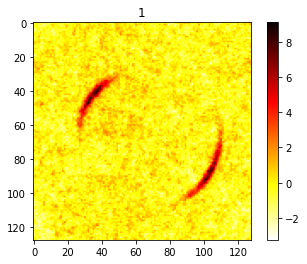

In [9]:
lens, label = next(generator(1)())
plt.imshow(preprocess(lens, label)[0][..., 0], cmap="hot_r")#, norm=ImageNormalize(stretch=LogStretch()))
plt.colorbar()
plt.title(f"{label:d}") 

In [10]:
batch_size=10
dataset = tf.data.Dataset.from_generator(generator(epoch_length), 
                                         output_signature=(
                                             tf.TensorSpec(shape=(pixels, pixels, 1), dtype=tf.float32),
                                             tf.TensorSpec(shape=(), dtype=tf.int32)
                                         ))
dataset = dataset.map(preprocess).batch(batch_size)#.prefetch(tf.data.experimental.AUTOTUNE)

# test_dataset = tf.data.Dataset.from_generator(generator(int(0.1 * epoch_length)), 
#                                          output_signature=(
#                                              tf.TensorSpec(shape=(pixels, pixels, 1), dtype=tf.float32),
#                                              tf.TensorSpec(shape=(), dtype=tf.int32)
#                                          ))
# test_dataset = test_dataset.map(preprocess).batch(batch_size)

In [11]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("../models/einstein_ring_detector", monitor='loss', save_best_only=True, mode='auto', save_freq='epoch')
optim = tf.optimizers.Adam(lr=1e-3)
model = create_model()
model.compile(optim, loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 8)       208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

In [13]:
model.fit(dataset, epochs=8, callbacks=[checkpoint])

Epoch 1/8
100/100 [==============================] - 25s 51ms/step - loss: 1.8974


INFO:tensorflow:Assets written to: ../models/einstein_ring_detector/assets


INFO:tensorflow:Assets written to: ../models/einstein_ring_detector/assets


Epoch 2/8
100/100 [==============================] - 5s 51ms/step - loss: 1.1752


INFO:tensorflow:Assets written to: ../models/einstein_ring_detector/assets


INFO:tensorflow:Assets written to: ../models/einstein_ring_detector/assets


Epoch 3/8
100/100 [==============================] - 5s 51ms/step - loss: 0.8233


INFO:tensorflow:Assets written to: ../models/einstein_ring_detector/assets


INFO:tensorflow:Assets written to: ../models/einstein_ring_detector/assets


Epoch 4/8
 53/100 [==============>...............] - ETA: 2s - loss: 0.7415

KeyboardInterrupt: 

In [20]:
i = 0
for lens, label in dataset.as_numpy_iterator():
    if i == 1:
        break
    i += 1

In [1]:
ind = 1
pred = model(lens)
plt.imshow(lens[ind, ..., 0], cmap="hot_r")#, norm=ImageNormalize(stretch=LogStretch()))
plt.colorbar()
plt.title(f"true={label[ind]:d}, pred={pred[ind, 0]:.2f}") 

NameError: name 'model' is not defined

In [22]:
pred

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.99999845],
       [0.13803707],
       [0.99999917],
       [0.16808932],
       [0.9958205 ],
       [0.9996886 ],
       [0.99389935],
       [0.5061887 ],
       [0.41314423],
       [0.9998882 ]], dtype=float32)>